توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [2]:
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt
import torchvision.transforms.functional as trans_f
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.nn.parallel import DataParallel

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




<div dir="rtl">
<font face="B Nazanin" size="5">
چون حجم دیتا خیلی زیاد بود دیگر آگمنت نکردم
</font>
</div>

In [4]:
import numpy as np
import torchvision.transforms.functional as F

# function 1
def displacement(img):
    horizontal = torch.randint(-80, 80, (1,)).item()
    vertical = torch.randint(-80, 80, (1,)).item()
    img = trans_f.affine(img, angle=0, translate=(horizontal, vertical), scale=1, shear=0, fill=torch.mean(img).item())
    
    return img

# function 2
def rotation(img):
    angle = torch.randint(-80, 80, (1,)).item()
    img = trans_f.affine(img, angle=angle, translate=(0, 0), scale=1, shear=0, fill=torch.mean(img).item())

    return img

# function 3
def scaling(img):
    scale = torch.FloatTensor(1).uniform_(0.5, 1.5).item()
    img = trans_f.affine(img, angle=0, translate=(0, 0), scale=scale, shear=0, fill=torch.mean(img).item())

    return img

# Function 4
def brightness(img):  ## for augmentation
    brightness_factor = np.random.uniform(0.2, 2.0)
    img = F.adjust_brightness(img, brightness_factor)

    return img

# Function 5
def blurring(img):  # for augmentation
    kernel_size = np.random.choice([3, 5, 7])  # Randomly choose kernel size from 3, 5, or 7
    img = cv2.GaussianBlur(img.numpy(), (kernel_size, kernel_size), 0)
    img = torch.from_numpy(img)

    return img

# Function 6
def gaussian_noise(img):  # for augmentation
    height, width, channels = img.shape
    mean = 0
    sigma = np.random.uniform(0.1, 0.2)  # Randomly choose sigma value

    gaussian = np.random.normal(mean, sigma, (height, width, channels))
    img = img.numpy() + gaussian

    img = np.clip(img, 0, 1)
    img = torch.from_numpy(img)

    return img


<div dir="rtl">
<font face="B Nazanin" size="5">

در زیر کلاس customdataset
را به گونه ای نوشته ام که با هر بار 
__getitem__
کردن علان
علاوه بر تصویر اصلی
تصوریر تغییر یافته را هم برگرداند

لیبلی که برای هر تصویر تغییر یافته برمیگردانیم یک سه تایی است که اگر 
هر کدام از اعضای آن یک باشد یعنی تغییر مربوط به آن انجام شده است.

برای اعمال کردن تغییر، 
ابتدا یک عدد رندوم بین 1 تا 3 انتخاب میکنیم که تعیین کننده ی تعداد تغییرات است.
سپس یک بردار رندوم درست میکنیم که تعداد یک های آن برابر با عدد انتخاب شده باشد.
سپس نظیر هر اندیس یک در بردار رندوم، تغییر مربوطه را انجام میدهیم.

توجه کنید چون دیتا خیلی بزرگ است امکان نداشت همه تصاویر تغییر یافته را در یک لیست نگه داریم

</font>
</div>

In [5]:
class CustomDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        original_img = self.dataset[idx][0]

        # Generate a random label vector with size 3
        num_ones = np.random.choice([1, 2, 3])  # Randomly choose 1, 2, or 3 ones
        label = np.zeros(3)
        label[:num_ones] = 1
        np.random.shuffle(label)

        changed_image = original_img
        if label[0] == 1:
            changed_image = displacement(changed_image)
        if label[1] == 1:
            changed_image = rotation(changed_image)
        if label[2] == 1:
            changed_image = scaling(changed_image)

        return original_img, changed_image, label.astype(np.float32)

    def __len__(self):
        return len(self.dataset)


<div dir="rtl">
<font face="B Nazanin" size="5">
چون دیتاست بزرگ است 10 درصد برای ولیدیشن درنظر گرفته ام
</font>
</div>

In [6]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


train_dataset   = datasets.ImageFolder('ADEChallengeData2016', transform=transform)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

dataset_train   = CustomDataset(train_dataset)
dataset_val     = CustomDataset(val_dataset)

test_dataset    = datasets.ImageFolder('release_test', transform=transform)
dataset_test    = CustomDataset(test_dataset)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader= DataLoader(dataset_test, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

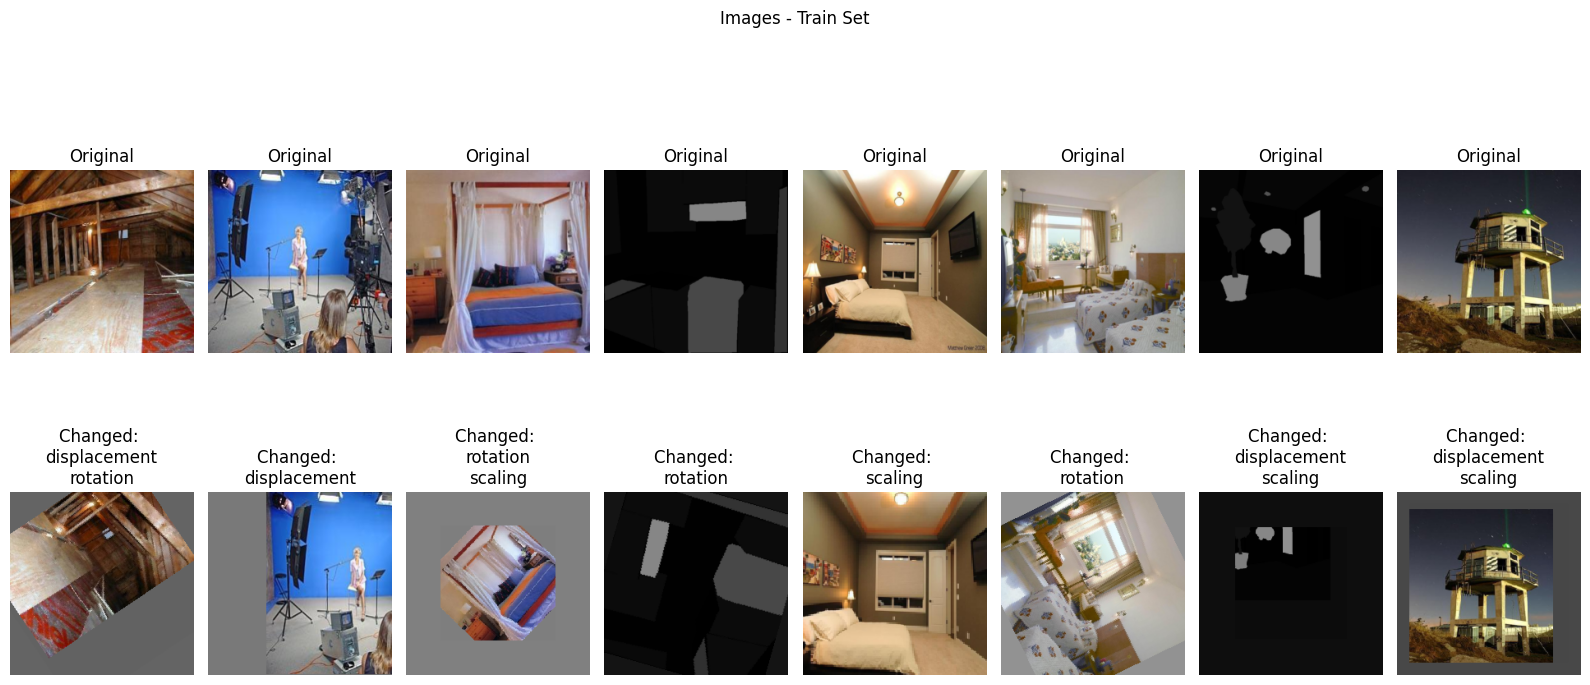

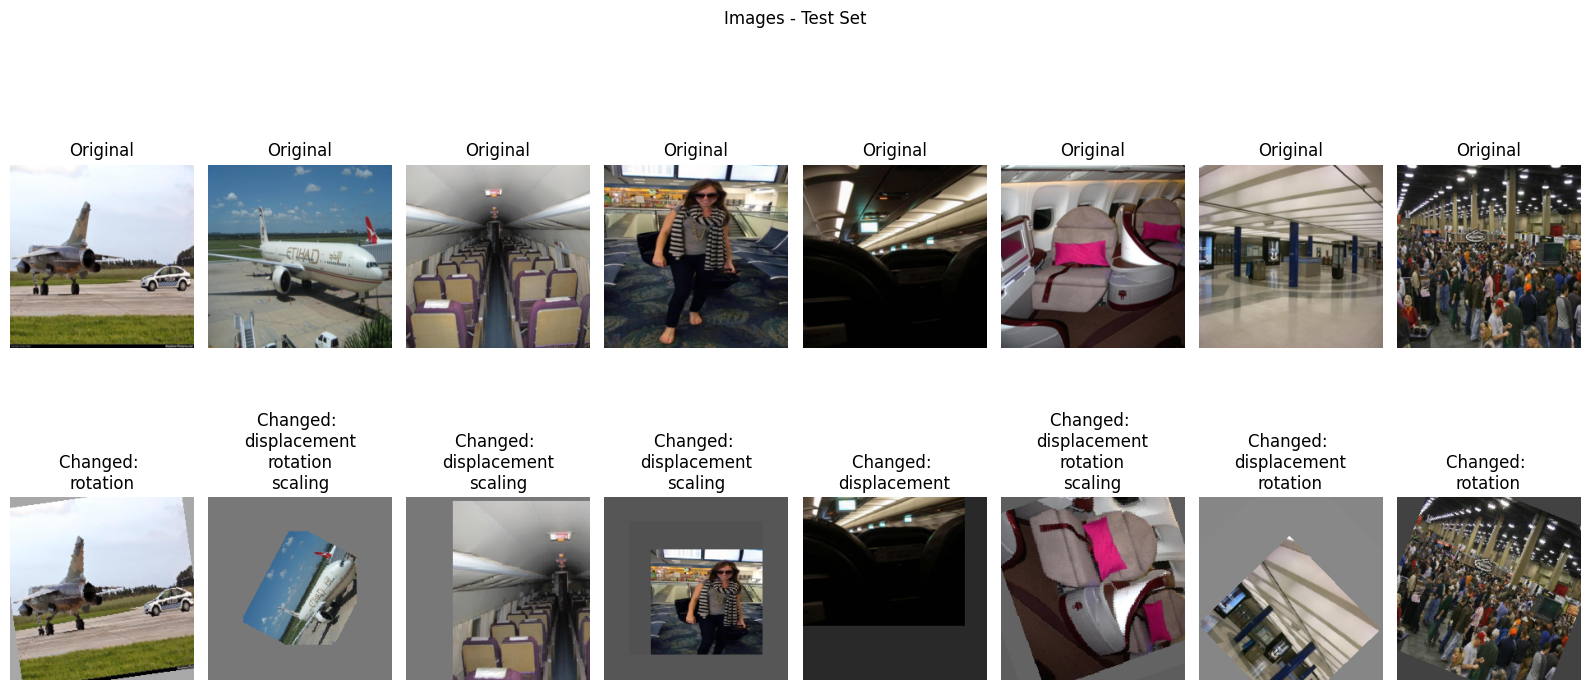

In [7]:
## To Do  : show 8 images from train_loader & 8 images from test_loader

from torchvision.utils import make_grid

def apply_label_changes(img, label):
    changed_image = img.clone()
    if label[0] == 1:
        changed_image = displacement(changed_image)
    if label[1] == 1:
        changed_image = rotation(changed_image)
    if label[2] == 1:
        changed_image = scaling(changed_image)
    return changed_image

def show_images_with_labels(loader, title):
    dataiter = iter(loader)
    images, changed_images, labels = next(dataiter)

    fig, axes = plt.subplots(2, 8, figsize=(16, 8))
    axes = axes.flatten()

    for i in range(8):
        label_str = ""
        if labels[i][0] == 1:
            label_str = label_str + "\ndisplacement"
        if labels[i][1] == 1:
            label_str = label_str + "\nrotation"
        if labels[i][2] == 1:
            label_str = label_str + "\nscaling"
        
        original_image = np.transpose(images[i].numpy(), (1, 2, 0))
        changed_image = np.transpose(changed_images[i].numpy(), (1, 2, 0))

        axes[i].imshow(original_image)
        axes[i].set_title('Original')
        axes[i].axis('off')

        axes[i+8].imshow(changed_image)
        axes[i+8].set_title(f'Changed: {label_str}')
        axes[i+8].axis('off')

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Show images from the training set
show_images_with_labels(train_loader, 'Images - Train Set')

# Show images from the test set
show_images_with_labels(test_loader, 'Images - Test Set')

<div dir="rtl">
<font face="B Nazanin" size="5">
در این قسمت توابع آگمنت را امتحان مبکنم ولی استفاده نخواهم کرد زیرا دیتاست بزرگ است
</font>
</div>

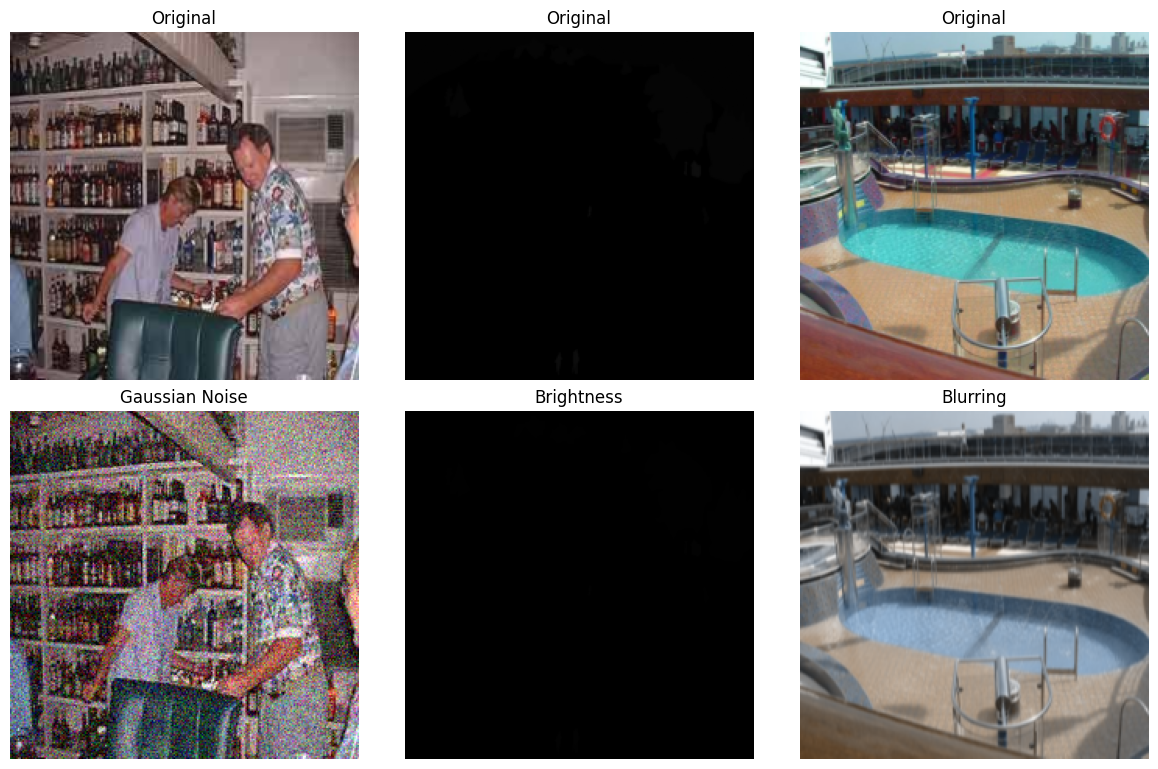

In [8]:
dataiter = iter(train_loader)
images, _, labels = next(dataiter)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Original image
original_image = np.transpose(images[0].numpy(), (1, 2, 0))
axes[0].imshow(original_image)
axes[0].set_title('Original')
axes[0].axis('off')

original_image = np.transpose(images[1].numpy(), (1, 2, 0))
axes[1].imshow(original_image)
axes[1].set_title('Original')
axes[1].axis('off')

original_image = np.transpose(images[2].numpy(), (1, 2, 0))
axes[2].imshow(original_image)
axes[2].set_title('Original')
axes[2].axis('off')

# Augment with gaussian noise
changed_image_gaussian_noise = np.transpose(gaussian_noise(images[0]).numpy(), (1, 2, 0))
axes[3].imshow(changed_image_gaussian_noise)
axes[3].set_title('Gaussian Noise')
axes[3].axis('off')

# Augment with brightness
changed_image_brightness = np.transpose(brightness(images[1]).numpy(), (1, 2, 0))
axes[4].imshow(changed_image_brightness)
axes[4].set_title('Brightness')
axes[4].axis('off')

# Augment with blurring
changed_image_blurring = np.transpose(blurring(images[2]).numpy(), (1, 2, 0))
axes[5].imshow(changed_image_blurring)
axes[5].set_title('Blurring')
axes[5].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

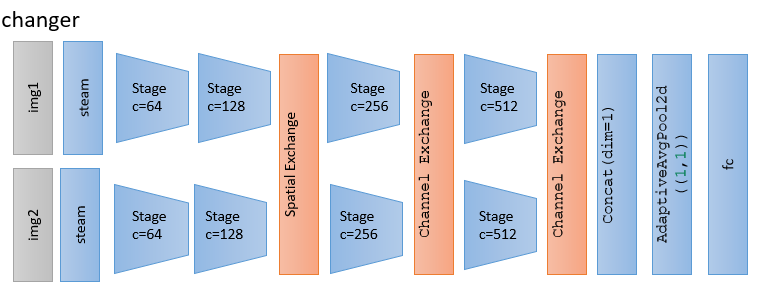

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


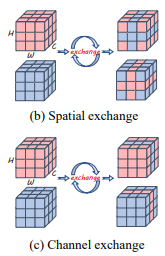

In [9]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

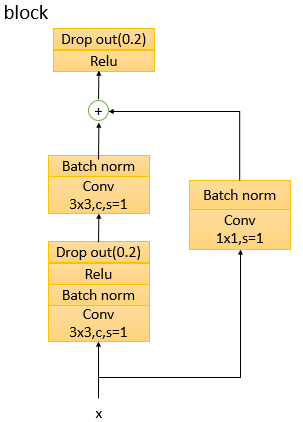

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





<div dir="rtl">
<font face="B Nazanin" size="5">
1)
چون سایز کرنل سه است برای اینکه سایز خروجی همانند سایز ورودی باشد باید از پدینگ یک استفاده کنیم.
چرا که برای حفظ سایز باید رابطه زیر برقرار باشد:
</font>
</div>

$$ w-1 = 2p $$


<div dir="rtl">
<font face="B Nazanin" size="5">
سایز خروجی کانو یک در یک برای جمع پذیری همان c انتخاب کردم

2)
دلیل استفاده از کانو یک در یک این است که ما میخواهیم از آن 
به عنوان باتلنک استفاده کنیم و لایه هارا کم کنیم
در ضمن این مسیر مانند یک اسکیپ کانکشن هم عمل میکند
  از طرفی میخواهیم از این کانو برای انتخاب کانال های مهم استفاده کنیم.
</font>
</div>

In [10]:
class block(nn.Module):
    def __init__(self, in_channel, c):
        super(block, self).__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(in_channel, c, 3, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(c, c, 3, padding=1),
            nn.BatchNorm2d(c),
        )
        
        self.skip_path = nn.Sequential(
            nn.Conv2d(in_channel, 1, 1),
            nn.BatchNorm2d(1)
        )
        
        self.final_path = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        out = self.main_path(x) + self.skip_path(x)
        out = self.final_path(out)
        return out

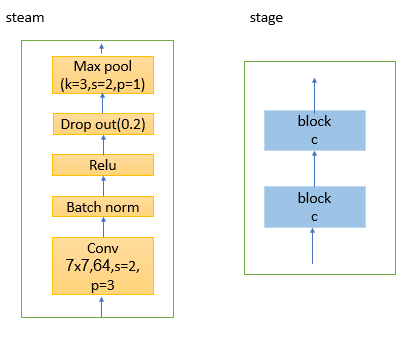

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

<div dir="rtl">
<font face="B Nazanin" size="5">
در آخر FC
یک سیگموید هم گذاشتم تا نگذارم خروجی از یک بیشتر شود
</font>
</div>

In [11]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
          nn.Conv2d(3, 64, 7, stride = 2, padding = 3),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.MaxPool2d(3, stride = 2, padding = 1),
        )

    self.stage1= self._make_stage(64,64)
    self.stage2= self._make_stage(64,128)
    self.stage3= self._make_stage(128,256)
    self.stage4= self._make_stage(256,512)

    self.spatial_exchange = SpatialExchange(p=1/2)
    self.channel_exchange = ChannelExchange(p=1/2)
    
    self.fc = nn.Linear(1024, 3)



  def _make_stage(self,in_channel, c):
    layers = []
    layers.append(block(in_channel, c))
    layers.append(block(c, c))
    return nn.Sequential(*layers)




  def forward(self,x1,x2):

    out1 = self.steam(x1)
    out1 = self.stage1(out1)
    out1 = self.stage2(out1)

    out2 = self.steam(x2)
    out2 = self.stage1(out2)
    out2 = self.stage2(out2)

    out1, out2 = self.spatial_exchange(out1, out2)

    out1 = self.stage3(out1)
    out2 = self.stage3(out2)

    out1, out2 = self.channel_exchange(out1, out2)

    out1 = self.stage4(out1)
    out2 = self.stage4(out2)

    out1, out2 = self.channel_exchange(out1, out2)

    out = torch.cat((out1, out2), 1)
    out = nn.AdaptiveAvgPool2d((1,1))(out)
    out = nn.Flatten()(out)
    out = self.fc(out)
    out = nn.Sigmoid()(out)


    return out

<div dir="rtl">
<font face="B Nazanin" size="5">

اگر میخواهید فرایند training
را از ابتدا انجام دهید
سلول زیر را ار کامنت خارج کرده و اجرا کنید و سپس بقیه سلول ها را اجرا کنید
    
البته به صورت خودکار اگر مدل ذخیره شده در کنار نوت بوک نباشد
فرایند ترینینگ از ابتدا انجام خواهد شد


</font>
</div>

In [12]:
# ## To Do
# device = "cuda" if torch.cuda.is_available() else "cpu"

# print("device" = device)


# model=changer(block,SpatialExchange,ChannelExchange).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer= optim.Adam(model.parameters(), lr=0.001)

# model_path = 'HW3_Q3_model.pth'

# epoch = 0
# Loss_train = []
# Loss_val=[]
# torch.save({
#     'epoch': epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'Loss_train': Loss_train,
#     'Loss_val': Loss_val,
# }, model_path)

##Train & validation


<div dir="rtl">
<font face="B Nazanin" size="5">
تابع زیر را برای تست مدل نوشته ام

توجه کنید که اگر خروجی بالای نیم باشد آن را به یک گرد میکنیم و یعنی آن تغییر روی عکس صورت گرفته
</font>
</div>

In [13]:
def evaluate_model(model, dataloader, criterion, threshold = 0.5, device="cuda"):
    model.eval()

    total_loss = 0
    num_correct = 0
    num_total = 0
    
    with torch.no_grad():
        print()
        for original_images, changed_images, labels in tqdm(dataloader):
            original_images = original_images.to(device)
            changed_images = changed_images.to(device)
            labels = labels.to(device)
            
            outputs = model(original_images, changed_images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            outputs[outputs > threshold] = 1
            outputs[outputs <= threshold]  = 0
            
            num_correct += torch.sum(outputs == labels).item()

            num_total += len(outputs)*3

    return num_correct/num_total, total_loss/num_total

<div dir="rtl">
<font face="B Nazanin" size="5">
در cell
زیر فرایند trainig
را انجام میدهیم. توجه کنید که در ابتدا مدل ذخیره شده را لود میکنیم پس اگر میحواهید از ابتدا ترین را انجام دهید 
 باید دو cell
قبل را از کامنت خارج کنید و اجرا کنید تا یک مدل خام ذخیره کند.
    
توجه کنید که چون در هر بار اجرای cell
زیر مدل لود میشود میتوانید هر تعداد بار که خواستید با اجرای cell
زیر فرایند ترین را ادامه دهید فقط در نظر بگیرید که حتی شماره epoch
هم ذخیره میشود پس اگر میخواهید تعدادد
epoch
بیشتری اجرا کنید
کافی است
متغیر 
max_epoch
را افزایش دهید.
    
اگر این کار را نکنید چون در آخرین بار آموزش تا آن ایپاک پیش رفته ایم دیگر بیشتر ترین نمیشود


</font>
</div>

<div dir="rtl">
<font face="B Nazanin" size="5">
توجه کنید چون کلاس ها صفر و یک هستند
من 
CrossEntropyLoss
را برگزیدم
</font>
</div>

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device", device)


model = changer(block,SpatialExchange,ChannelExchange)
criterion = nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=0.001)
model_path = 'HW3_Q3_model.pth'
epoch = 0
Loss_train = []
Loss_val=[]

if os.path.exists(model_path):
    checkpoint = torch.load(model_path)
else:
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'Loss_train': Loss_train,
        'Loss_val': Loss_val,
    }, model_path)

## ======================================
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
Loss_train = checkpoint['Loss_train']
Loss_val = checkpoint['Loss_val']
epoch = checkpoint['epoch']

model = model.to(device)
optimizer= optim.Adam(model.parameters(), lr=0.001)
model = DataParallel(model)

max_epoch = 3
threshold = 0.5

model.train()
while epoch < max_epoch:
    Sum_loss = 0
    num_correct_train = 0
    num_total = 0
    print(f'epoch: {epoch}')
    for original_images, changed_images, labels in tqdm(train_loader):
        original_images = original_images.to(device)
        changed_images = changed_images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(original_images, changed_images)
        outputs[outputs > threshold] = 1
        outputs[outputs <= threshold]  = 0
        num_correct_train += torch.sum(outputs == labels).item()
        num_total += len(outputs)*3
        
        loss = criterion(outputs, labels)
        Sum_loss += loss.item()
        loss.backward()
        optimizer.step()

    average_loss = Sum_loss / num_total 
    num_correct_train = num_correct_train /num_total  
    Loss_train.append(average_loss)
    
    num_correct_val, loss_val = evaluate_model(model, val_loader, criterion,
                   threshold = threshold, device=device)
    
    print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train*100):.3f} %,\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)*100 :.3f} %')
    Loss_val.append(loss_val)
    
    epoch = epoch + 1

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.module.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'Loss_train': Loss_train,
        'Loss_val': Loss_val,
    }, model_path)
    
   


device cuda
epoch: 2


100%|██████████| 1250/1250 [21:03<00:00,  1.01s/it]


100%|██████████| 139/139 [01:20<00:00,  1.73it/s]


loss_TRAIN =3032.544,acc_train=44.698 %,	 loss_val= 0.023, acc_val=43.606 %


<div dir="rtl">
<font face="B Nazanin" size="5">
تا سه ایپاک 
train
کردم که دیدم که دیگر تغییری نمیکند
</font>
</div>

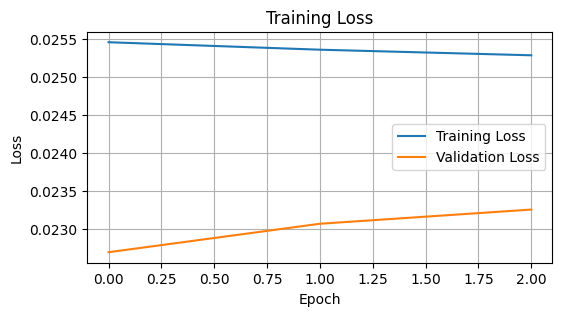

In [19]:
# Plot Loss
plt.figure(figsize=(6, 3))
plt.plot(Loss_train, label='Training Loss')
plt.plot(Loss_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()


#Test


In [21]:
checkpoint = torch.load(model_path)
model = changer(block,SpatialExchange,ChannelExchange)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
Loss_train = checkpoint['Loss_train']
Loss_val = checkpoint['Loss_val']
epoch = checkpoint['epoch']

model.to(device)
model = DataParallel(model)
## To Do test
acc_correct_test, loss_test = evaluate_model(model, test_loader, criterion,
                   threshold = threshold, device=device)
    
print(f' loss_test= {loss_test:.3f}, acc_test={acc_correct_test*100:.3f} %')


100%|██████████| 105/105 [01:06<00:00,  1.58it/s]

 loss_test= 0.023, acc_test=44.053 %


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

در زیر مشاهده میشود که با یک تغییر از همه بهتر شناسایی شده اند

In [24]:
model.eval()

correct_1 = 0
correct_2 = 0
correct_3 = 0

with torch.no_grad():
    print()
    for original_images, changed_images, labels in tqdm(test_loader):
        original_images = original_images.to(device)
        changed_images = changed_images.to(device)
        labels = labels.to(device)

        outputs = model(original_images, changed_images)
        outputs[outputs > threshold] = 1
        outputs[outputs <= threshold]  = 0
        
        for predicted_label, true_label in zip(outputs, labels):
            
            num_ones = int(true_label.sum().item())
            if any(predicted_label == true_label):
                if num_ones == 1:
                    correct_1 += 1
                elif num_ones == 2:
                    correct_2 += 1
                elif num_ones == 3:
                    correct_3 += 1


print(f'Correct_1: {correct_1}')
print(f'Correct_2: {correct_2}')
print(f'Correct_3: {correct_3}')
        



100%|██████████| 105/105 [01:06<00:00,  1.58it/s]

Correct_1: 1137
Correct_2: 776
Correct_3: 1079
